# ResNet18 Test

This code is a test of an adversarial attack on the ResNet18 architecture as proposed by: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf). This notebook focuses only on the MNIST dataset of handwritten digits.

The code is "stolen" from the following GitHub [directory](https://github.com/pytorch/vision/tree/main/torchvision). All of the code from the GitHub directory lies in the "Support_Code" folder. Both `internally_replaced_utils` and `utils` are in the *torchvision* directory, while `ResNet18_Stolen_GitHub_Code` is the `resnet.py` file from the *models* subdirectory.


## Basic Imports

In [13]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, utils
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
%matplotlib inline

# Importing the "resnet18" function from the GitHub code
from Support_Code.ResNet18_Stolen_GitHub_Code import resnet18

# Path for where we save the model
# this is a magic tool that will come in handy later ;)
saveModelPath = "../trainedModels/adversarial_ResNet18_Numbies.pth"

## Important if you want to train again, set this to True
trainAgain = False

## Basic configuration and epsilons
We need some epsilons indicating how much noise is added. This is kept as a list. For different sizes of attack. How great the attack. Then we also need to specify whether we use the GPU (Cuda) or not. With my potato the CPU is the only choice.

In [14]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Downloading data

Downloading those pesky numbies.

In [15]:
batch_size = 32 # batch size in the binary table is best: 2, 4, 8, 16... 32

train_data = datasets.MNIST(
    root = '../data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

trainloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
    )

test_data = datasets.MNIST(
    root = '../data', 
    train = False, 
    transform = ToTensor()
)

testloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
    )

## How do the numbers be looking?

Plot some of the numbers from the MNIST training set

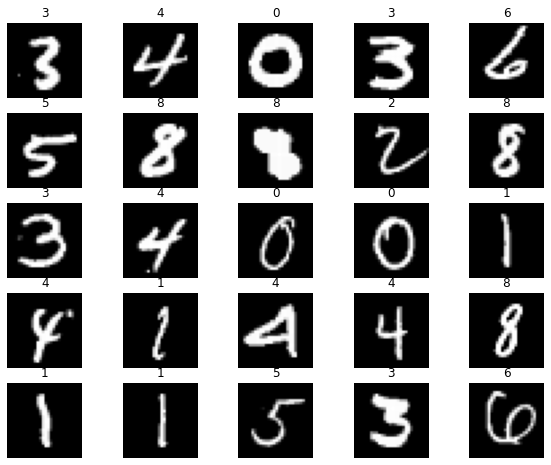

In [16]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Intermediary test
Testing whether the pics are in range [0,1]

In [17]:
I_Want_Intermediary_Test = False
Nsamples = 10

if I_Want_Intermediary_Test:
    # Finding max of input images
    from math import inf
    maxNum = -inf
    minNum = inf
    for i in range(Nsamples):
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, _ = train_data[sample_idx]
        tempMax = torch.max(img)
        tempMin = torch.min(img)
        if maxNum < tempMax:
            maxNum = tempMax
        if tempMin < minNum:
            minNum = tempMin

    print(f"Smallest in number in these images: {minNum}\n Greatest number in sample images: {maxNum}")
    

## Downloading the ResNet18 model

Getting the model from the stolen GitHub code.

In [18]:
# Returns the resnet18 model pretrained on imageNet
model = resnet18(pretrained=False).to(device)


# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
lrn_rt = 0.5e-3

loss_fn = nn.CrossEntropyLoss()

# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt)

## Defining loss and optimization function

Both the loss function and the optimization function needs to be defined for this particular neural network.
They are defined as follows.

(Why it is always that CrossEntropyLoss.. I do not know)

In [20]:
lrn_rt = 0.5e-3

loss_fn = nn.CrossEntropyLoss()

# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt)

## The Training and Testing Loop

The loops for training and testing:

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Compute prediction and loss
        pred = model(inputs)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

## Training the network

Obviously we also need to fit some weights, so here is the code for training the network.

In [22]:
# exists is a function from os.path (standard library)
trained_model_exists = exists(saveModelPath)

# We train if we haven't already trained
# or we want to train again.
if not trained_model_exists or trainAgain:
    epochs = 5
    accuracies = [0]*epochs
    losses = [0]*epochs

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(trainloader, model, loss_fn, optimizer)
        accuracy, avgloss = test_loop(testloader, model, loss_fn)
        
        # This is just extra for plotting
        accuracies[t] = accuracy
        losses[t] = avgloss
    print("Done!")
else:
    print("Have already trained this model once!")



Epoch 1
-------------------------------
loss: 6.886225  [    0/60000]


KeyboardInterrupt: 

### Optional code for plotting
If you wanna see the development of the accuracy and the avg loss, this is the plot for you!

In [ ]:
# Only run this if we have trained, so that we have an available plot
if not trained_model_exists or trainAgain:
    xVals = list(range(1, epochs + 1))

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(f"Accuracy and loss over {epochs} epochs")

    ax1.plot(xVals, accuracies, 'o-')
    ax1.set_ylabel("Accuracy over epochs")

    ax2.plot(xVals, losses, '.-')
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("AVG loss over epochs")

    plt.show()
else:
    print("We didn't train, so we can't plot anything...")

## Saving and loading model

### Saving

Here is quite a good [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for saving and loading models.

In [ ]:

if not trained_model_exists or trainAgain:
    torch.save(model.state_dict(), saveModelPath)
    print(f"Saved PyTorch Model State to {saveModelPath}")

### Load
Loading the model afterwards... quite an important part of the process.

In [ ]:
model = resnet18(pretrained=False).to(device)
model.load_state_dict(torch.load(saveModelPath))

## FGSM Attack
(Fast Gradient Sign Method) Attack.
Here we define the function that creates the adversarial example by disturbing the original image.

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing function
This is a testing function written by the peeps at pyTorch. It seems like it does a lot, I am not entirely sure what everything is though.

In [ ]:
def test( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        # print(f"Output:\n{output}")
        init_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        # print(f"Do we get this far?\n initial prediction: {init_pred}")
        init_pred_index = init_pred[1][0]
        # print(f"Do we get this far?\n initial prediction index: {init_pred_index}")
        

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred_index.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        # NOTE: Output with the way I (Felix) did it is a tuple, where second index
        # is stating that gradient is on... or something.
        # So I just extract the first index.
        # NOTE: THIS correction was a huge mistake.
        output = model(perturbed_data)
        # print(f"second output: {output}")

        # Check for success
        final_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        # final_pred =  ((values : tensor_type, grad_fn : string_type), indices : tensor_type)
        # print(f"final prediction: {final_pred}")
        final_pred_index = final_pred[1]
        # final_pred_index = tensor
        # print(f"Final prediction indedx: {final_pred_index}")
        
        if final_pred_index.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred_index.item(), final_pred_index.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred_index.item(), final_pred_index.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Finally we run the attack
This also saves some values, so that we can see how the accuracy falls along with greater epsilon (error) rates.


In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, loaders["test"], eps)
    accuracies.append(acc)
    examples.append(ex)

## Results
We make an **accuracy** vs. **epsilon*** plot and see that there is a clear correlation.

### Accuracy vs. Epsilon

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples
Here we show some of the images that are the results of adversarial attacks, alongside the prediction by the network :) 

In [ ]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        
        # CIFAR is complicated so we need to reshape and normalize..
        reshaped_ex = np.transpose(ex, (1, 2, 0))
        #print(f"min: {min(reshaped_ex.flatten())}")
        #normalised_ex = reshaped_ex / 2     # unnormalize
        #print(f"max: {max(reshaped_ex.flatten())}")
        
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(reshaped_ex)
plt.tight_layout()
plt.show()